### Energy Analysis Notebook
#### Micro Renewable Energy System - Generation, Tariffs, Export & Battery Optimisation

This notebook analyses **30 minute smart meter electricity data** to compare:
- Electricity tariffs
- Grid export vs battery storage strategies
- EV night charging
- Household usage behaviour

The goal is to determine the **most cost effective energy management strategy** for a modern home using:
- Solar PV
- Smart metering
- Time of use tariffs
- EV charging
- Battery storage


---

### Objectives

- Analyse real and synthetic **30 minute electricity consumption data**
- Compare multiple **tariff structures**

- Evaluate the financial impact of:
    - Exporting to the grid
    - Storing energy in a battery

- Compare two household profiles:
    - All day occupancy
    - Away 9am to 5pm with EV charging

- Determine:
    - Annual electricity cost
    - Export revenue
    - Battery payback period
    - ROI (Return on Investment)

    ---

### Case Study Definitions

#### Case Study 1 - All Day Occupancy
- High electricity usage throughout the day
- High solar self consumption


#### Case Study 2 - Away 9am to 5pm with EV Charging
- Low daytime usage
- High evening peak (5:30pm to 7:30pm)
- Overnight EV charging
- High solar generation during working hours

---

### Import Required Libraries

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Configure pandas to display all columns in DataFrames
pd.set_option("display.max_columns", None)

### Load the Datasets

In [8]:

import pandas as pd

%pip install openpyxl

import os

# Define file paths for the datasets
file_case1 = r"C:\Users\CAD-PC\Desktop\GitHub - Cloned Repository\PFDA\Project\Data Set 1 - All Day Usage - 30 Min Interval Data.xlsx"  
file_case2 = r"C:\Users\CAD-PC\Desktop\GitHub - Cloned Repository\PFDA\Project\Data Set 2 - 9am to 5pm Low Usage - 30 Min Interval Data.xlsx"  

# Check if the files exist
if not os.path.exists(file_case1):
	raise FileNotFoundError(f"File not found: {file_case1}. Please provide the correct path.")
if not os.path.exists(file_case2):
	raise FileNotFoundError(f"File not found: {file_case2}. Please provide the correct path.")

# Load the All Day Occupancy dataset
df_case1 = pd.read_excel(file_case1, engine='openpyxl')     

# Load the Low Daytime Usage with EV dataset
df_case2 = pd.read_excel(file_case2, engine='openpyxl')     

# Show previews of both datasets
df_case1.head(), df_case2.head()


Note: you may need to restart the kernel to use updated packages.


(        Date  00:00:00  00:30:00  01:00:00  01:30:00  02:00:00  02:30:00  \
 0 2024-11-28     0.526     0.469     0.477     0.676     0.972     0.885   
 1 2024-11-29     0.437     0.448     0.483     0.492     0.473     0.487   
 2 2024-11-30     0.563     0.552     0.534     0.486     0.517     0.531   
 3 2024-12-01     0.549     0.521     0.462     0.475     0.476     0.491   
 4 2024-12-02     0.594     0.522     0.497     0.448     0.525     0.507   
 
    03:00:00  03:30:00  04:00:00  04:30:00  05:00:00  05:30:00  06:00:00  \
 0     0.893     0.732     0.476     0.479     0.599     0.583     0.621   
 1     0.483     0.486     0.484     0.955     0.781     0.741     1.375   
 2     0.532     0.545     0.536     0.532     0.550     0.522     0.532   
 3     0.452     0.415     0.474     0.475     0.595     0.603     0.877   
 4     0.516     0.502     0.465     0.508     0.634     0.726     1.656   
 
    06:30:00  07:00:00  07:30:00  08:00:00  08:30:00  09:00:00  09:30:00  \
 0

### Data Validation 

In [9]:
# Examine the structure and validity of both datasets

print("CASE STUDY 1 - STRUCTURE SUMMARY\n")
df_case1.info()    # Displays column names, data types, and non null counts 
print("\n----------------------------------------\n")

print("CASE STUDY 2 - STRUCTURE SUMMARY\n")
df_case2.info()    
print("\n----------------------------------------\n")


print("COLUMN NAMES IN CASE STUDY 1:\n")
print(df_case1.columns.tolist())     # Print ordered list of all column names

print("\nCOLUMN NAMES IN CASE STUDY 2:\n")
print(df_case2.columns.tolist())
print("\n----------------------------------------\n")



# Identify all columns except the Date column
interval_columns_case1 = df_case1.columns[1:]    # Assumes column 0 is 'Date'
interval_columns_case2 = df_case2.columns[1:]

print(f"Case Study 1 interval column count: {len(interval_columns_case1)}")  # Should be 48
print(f"Case Study 2 interval column count: {len(interval_columns_case2)}\n")

# Validate expected number of intervals
if len(interval_columns_case1) == 48:
    print("✔ Case Study 1 contains the correct number of 30 minute interval columns.\n")
else:
    print("❌ Case Study 1 does NOT contain 48 interval columns. Please check dataset formatting.\n")

if len(interval_columns_case2) == 48:
    print("✔ Case Study 2 contains the correct number of 30 minute interval columns.\n")
else:
    print("❌ Case Study 2 does NOT contain 48 interval columns. Please check dataset formatting.\n")



print("Checking for missing values in Case Study 1...\n")
print(df_case1.isna().sum())    # Counts missing values in each column

print("\nChecking for missing values in Case Study 2...\n")
print(df_case2.isna().sum())
print("\n----------------------------------------\n")




# Convert to numeric and report errors if found
case1_non_numeric = df_case1[interval_columns_case1].apply(lambda col: pd.to_numeric(col, errors="coerce")).isna().sum().sum()
case2_non_numeric = df_case2[interval_columns_case2].apply(lambda col: pd.to_numeric(col, errors="coerce")).isna().sum().sum()

print(f"Case Study 1 non-numeric entries in interval columns: {case1_non_numeric}")
print(f"Case Study 2 non-numeric entries in interval columns: {case2_non_numeric}\n")

if case1_non_numeric == 0 and case2_non_numeric == 0:
    print("✔ All interval columns contain valid numeric data.\n")
else:
    print("❌ One or more interval columns contain invalid (non-numeric) values.\n")




# Attempt to convert Date column to datetime format
df_case1['Date'] = pd.to_datetime(df_case1['Date'], errors='coerce')
df_case2['Date'] = pd.to_datetime(df_case2['Date'], errors='coerce')

print("Date conversion complete.\n")

# Check for date conversion failures (NaT values)
case1_bad_dates = df_case1['Date'].isna().sum()
case2_bad_dates = df_case2['Date'].isna().sum()

print(f"Case Study 1 invalid dates: {case1_bad_dates}")
print(f"Case Study 2 invalid dates: {case2_bad_dates}\n")

# Check that dates are continuous (no missing days)
case1_date_range = df_case1['Date'].max() - df_case1['Date'].min()
case2_date_range = df_case2['Date'].max() - df_case2['Date'].min()

print(f"Case Study 1 date span: {case1_date_range}")
print(f"Case Study 2 date span: {case2_date_range}\n")

print("✔ Dataset validation complete.\n")


CASE STUDY 1 - STRUCTURE SUMMARY

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 49 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      364 non-null    datetime64[ns]
 1   00:00:00  364 non-null    float64       
 2   00:30:00  364 non-null    float64       
 3   01:00:00  363 non-null    float64       
 4   01:30:00  363 non-null    float64       
 5   02:00:00  364 non-null    float64       
 6   02:30:00  364 non-null    float64       
 7   03:00:00  364 non-null    float64       
 8   03:30:00  364 non-null    float64       
 9   04:00:00  364 non-null    float64       
 10  04:30:00  364 non-null    float64       
 11  05:00:00  364 non-null    float64       
 12  05:30:00  364 non-null    float64       
 13  06:00:00  364 non-null    float64       
 14  06:30:00  364 non-null    float64       
 15  07:00:00  364 non-null    float64       
 16  07:30:00  364 non-null    fl

### Data Cleaning

In [10]:
# Clean both datasets by removing invalid rows, and converting data types


df_case1 = df_case1.dropna(subset=['Date'])    # Ensure every row has a valid date

df_case2 = df_case2.dropna(subset=['Date'])    # Ensure every row has a valid date


# All columns except the first ('Date') are interval readings
interval_cols_case1 = df_case1.columns[1:]     # Select all 30 minute interval columns for Case Study 1
interval_cols_case2 = df_case2.columns[1:]     # Select all 30 minute interval columns for Case Study 2



# Convert text values to numeric and replace conversion errors with NaN (which we will fill later)
df_case1[interval_cols_case1] = df_case1[interval_cols_case1].apply(
    lambda col: pd.to_numeric(col, errors='coerce')   # Converts strings to floats
)

df_case2[interval_cols_case2] = df_case2[interval_cols_case2].apply(
    lambda col: pd.to_numeric(col, errors='coerce')   # Same conversion for Case Study 2
)


# Replace missing reading with 0 kWh
df_case1[interval_cols_case1] = df_case1[interval_cols_case1].fillna(0)   
df_case2[interval_cols_case2] = df_case2[interval_cols_case2].fillna(0)   



# Sorting ensures the time series is in chronological order
df_case1 = df_case1.sort_values(by='Date')     
df_case2 = df_case2.sort_values(by='Date')    



# Resetting gives clean, sequential indexing starting from 0
df_case1 = df_case1.reset_index(drop=True)     
df_case2 = df_case2.reset_index(drop=True)     


# Print cleaning summary
print("CLEANING COMPLETE\n")

print("Case Study 1 Shape (rows, columns):", df_case1.shape)   
print("Case Study 2 Shape (rows, columns):", df_case2.shape)   

print("\nFirst dates after cleaning:")
print("Case Study 1 starts:", df_case1['Date'].min())         
print("Case Study 2 starts:", df_case2['Date'].min())

print("\nLast dates after cleaning:")
print("Case Study 1 ends:", df_case1['Date'].max())           
print("Case Study 2 ends:", df_case2['Date'].max())

print("\nMissing values remaining in Case Study 1:", df_case1.isna().sum().sum())   
print("Missing values remaining in Case Study 2:", df_case2.isna().sum().sum())


CLEANING COMPLETE

Case Study 1 Shape (rows, columns): (364, 49)
Case Study 2 Shape (rows, columns): (364, 49)

First dates after cleaning:
Case Study 1 starts: 2024-11-28 00:00:00
Case Study 2 starts: 2024-11-28 00:00:00

Last dates after cleaning:
Case Study 1 ends: 2025-11-26 00:00:00
Case Study 2 ends: 2025-11-26 00:00:00

Missing values remaining in Case Study 1: 0
Missing values remaining in Case Study 2: 0


### Daily Energy Usage Profiles

Case Study 1 Daily Usage Summary:

count    364.000000
mean      28.896113
std       11.343073
min        7.900000
25%       19.952250
50%       26.937000
75%       37.325500
max      101.436000
Name: Daily_kWh, dtype: float64

Case Study 2 Daily Usage Summary:

count    364.000000
mean      22.938212
std        5.357470
min       10.071384
25%       19.027592
50%       22.962210
75%       26.629841
max       56.873208
Name: Daily_kWh, dtype: float64


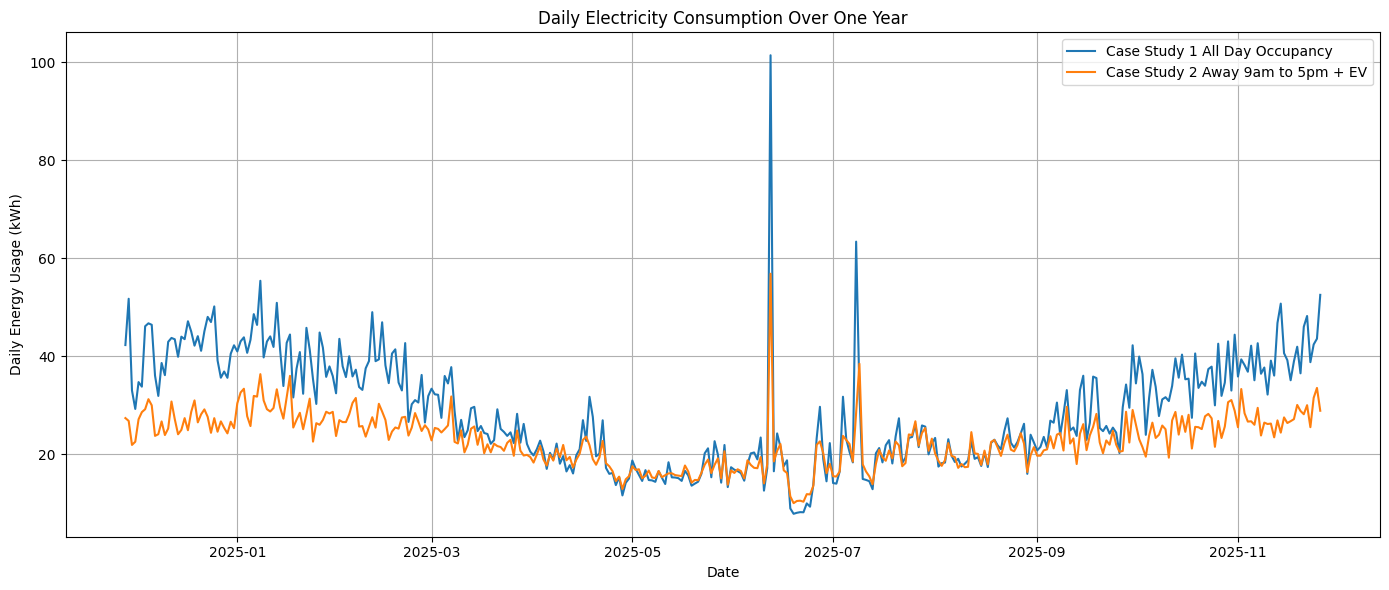

In [11]:
# Compute daily electricity consumption totals for both case studies and visualise their daily energy usage across the year.


# Sum all 48 half hour interval columns for case study 1
df_case1['Daily_kWh'] = df_case1[interval_cols_case1].sum(axis=1)    

# Sum all intervals for case study 2
df_case2['Daily_kWh'] = df_case2[interval_cols_case2].sum(axis=1)    



# Calculate daily totals
print("Case Study 1 Daily Usage Summary:\n")
print(df_case1['Daily_kWh'].describe())    # Shows mean, min, max, std for Case Study 1

print("\nCase Study 2 Daily Usage Summary:\n")
print(df_case2['Daily_kWh'].describe())    # Summary for Case Study 2



# Plot daily energy usage for both datasets
plt.figure(figsize=(14, 6))  # Set plot size

plt.plot(df_case1['Date'], df_case1['Daily_kWh'], label='Case Study 1 All Day Occupancy')    # Daily usage line plot for Case Study 1
plt.plot(df_case2['Date'], df_case2['Daily_kWh'], label='Case Study 2 Away 9am to 5pm + EV') # Daily usage plot for Case Study 2

plt.xlabel("Date")                          # Label for x axis
plt.ylabel("Daily Energy Usage (kWh)")       # Label for y axis
plt.title("Daily Electricity Consumption Over One Year")     # Plot title
plt.legend()                                 # Show legend to distinguish the two case studies
plt.grid(True)                               # Add grid lines for readability

plt.tight_layout()                            # Reduce whitespace and fit plot neatly
plt.show()                                    # Display the plot
